<a href="https://colab.research.google.com/github/michellbrito/CSCE_614_Term_Project/blob/main/CSCE_614_CNN_for_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Package to install

In [ ]:
#to install the measure metrics tool
#!pip install wandb

#Libraries

In [ ]:
# keras imports for the dataset and building our neural network
from keras.datasets import cifar10
#basics
from math import floor, sqrt, pi
from random import sample
import time
import timeit
#helpful progress bar
from tqdm.notebook import tqdm, trange

import warnings
warnings.filterwarnings("ignore")
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from keras.utils import to_categorical

from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten
import warnings
warnings.filterwarnings("ignore")  # Ignore some warning logs
from keras.models import Sequential

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from sklearn.model_selection import cross_validate, train_test_split


#Measuring Metrics
1) run the code below
2) click on the link
3) sign up if you need to
4) copy the code it gives you
5) paste it here
6) go back to the website, go to metrics. You will be able to see the metrics from there.

In [ ]:
import wandb
wandb.init()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Testing GPU. If "/device:GPU:0", that means it is using GPU for workload processing, otherwise, if " ", then it is using CPU for workload processing

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

#Loading the MNIST dataset

170500096/170498071 [==============================] - 4s 0us/step
Visualizing a random image (11th) from training dataset


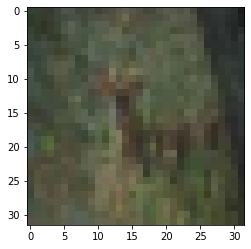

In [ ]:
# loading the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
print("Visualizing a random image (11th) from training dataset")
_ = plt.imshow(train_images[10])

#Preprocessing and reshaping

In [ ]:
# normalizing the data to help with the training
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

In [ ]:
# # building the input vector from the 32x32 pixels
train_images_3d = train_images.reshape(train_images.shape[0], 32, 32, 3)
test_images_3d = test_images.reshape(test_images.shape[0], 32, 32, 3)
train_images_3d = train_images_3d.astype('float32')
test_images_3d = test_images_3d.astype('float32')
print(train_images_3d.shape, test_images_3d.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)


#CNN Neural Network without optimized hyperparameters

In [ ]:
model = Sequential([Conv2D(50, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)), 
          Conv2D(75, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'), 
          MaxPooling2D(pool_size=(2,2)), Dropout(0.25),
          Conv2D(125, kernel_size=(1,1), strides=(1,1), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)), Dropout(0.25), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])

print(model.summary())

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_93 (Conv2D)           (None, 32, 32, 50)        200       
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 32, 32, 75)        3825      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_124 (Dropout)        (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 16, 16, 125)       9500      
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_125 (Dropout)        (None, 8, 8, 125)       

In [ ]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(train_images_3d, to_categorical(train_labels), epochs=10, batch_size=128,)

Epoch 1/10
391/391 [==============================] - 5s 13ms/step - loss: 1.6764 - accuracy: 0.3912
Epoch 2/10
391/391 [==============================] - 5s 13ms/step - loss: 1.4082 - accuracy: 0.4927
Epoch 3/10
391/391 [==============================] - 5s 13ms/step - loss: 1.3084 - accuracy: 0.5303
Epoch 4/10
391/391 [==============================] - 5s 13ms/step - loss: 1.2393 - accuracy: 0.5576
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - loss: 1.1845 - accuracy: 0.5788
Epoch 6/10
391/391 [==============================] - 5s 13ms/step - loss: 1.1486 - accuracy: 0.5912
Epoch 7/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0975 - accuracy: 0.6089
Epoch 8/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0691 - accuracy: 0.6203
Epoch 9/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0292 - accuracy: 0.6355
Epoch 10/10
391/391 [==============================] - 5s 13ms/step - loss: 1.0022 - accura

In [ ]:
performance = model.evaluate(test_images_3d, to_categorical(test_labels))
print("Accuracy on Test samples: {0}".format(performance[1]))

313/313 [==============================] - 1s 3ms/step - loss: 1.0592 - accuracy: 0.6252
Accuracy on Test samples: 0.6251999735832214


#HyperOpt: Optimizing Hyperparameters - DO NOT RUN THIS; SKIP SECTION

In [ ]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


def optimize_cnn(hyperparameter):
  
  cnn_model = Sequential([Conv2D(50, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation'], input_shape=(32,32,3)), 
          Conv2D(75, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation']), 
          MaxPooling2D(pool_size=(2,2)), Dropout(hyperparameter['dropout_prob']),
          Conv2D(125, kernel_size=hyperparameter['conv_kernel_size'], strides = hyperparameter['conv_stride'], padding='same', activation=hyperparameter['activation']),
          MaxPooling2D(pool_size=(2,2)), Dropout(hyperparameter['dropout_prob']), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])
  

  cnn_model.compile(optimizer=hyperparameter['optimizer'], loss='categorical_crossentropy', metrics=['accuracy'],)

  # create a training (50K samples) and validation (10K samples) subsets from training images.
  # Validation subset will be used to find the optimal hyperparameters
  train_X, train_y = train_images_3d[:40000], train_labels[:40000]
  valid_X, valid_y = train_images_3d[40000:], train_labels[40000:]

  _ = cnn_model.fit(train_X, to_categorical(train_y), epochs=10, batch_size=128, verbose=0)
  # Evaluate accuracy on validation data
  performance = cnn_model.evaluate(valid_X, to_categorical(valid_y), verbose=0)

  print("Hyperparameters: ", hyperparameter, "Accuracy: ", performance[1])
  print("----------------------------------------------------")
  # We want to minimize loss i.e. negative of accuracy
  return({"status": STATUS_OK, "loss": -1*performance[1], "model":cnn_model})
  

# Define search space for hyper-parameters
space = {
    # The kernel_size for convolutions:
    'conv_kernel_size': hp.choice('conv_kernel_size', [1, 3, 5]),
    # Uniform distribution in finding appropriate dropout values
    'dropout_prob': hp.uniform('dropout_prob', 0.1, 0.35),
    #choice of stride
    'conv_stride': hp.choice('conv_stride',[1,2]),
    #choice of activation
    'activation': hp.choice('activation', ['relu','selu','tanh']),
    # Choice of optimizer 
    'optimizer': hp.choice('optimizer', ['Adam', 'sgd']),
}

trials = Trials()

# Find the best hyperparameters
best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=25,
    )

print("==================================")
print("Best Hyperparameters", best)

# You can retrain the final model with optimal hyperparameters on train+validation data

# Or you can use the model returned directly
# Find trial which has minimum loss value and use that model to perform evaluation on the test data
test_model = trials.results[np.argmin([r['loss'] for r in trials.results])]['model']

performance = test_model.evaluate(test_images_3d, to_categorical(test_labels))

print("==================================")
print("Test Accuracy: ", performance[1])

Hyperparameters: 
{'activation': 'relu', 'conv_kernel_size': 3, 'conv_stride': 2, 'dropout_prob': 0.3083993613180913, 'optimizer': 'Adam'}
Accuracy: 
0.6665999889373779
----------------------------------------------------
Hyperparameters: 
{'activation': 'selu', 'conv_kernel_size': 5, 'conv_stride': 2, 'dropout_prob': 0.22768133388328765, 'optimizer': 'sgd'}
Accuracy: 
0.48170000314712524
----------------------------------------------------
Hyperparameters: 
{'activation': 'relu', 'conv_kernel_size': 3, 'conv_stride': 1, 'dropout_prob': 0.2236633847214457, 'optimizer': 'Adam'}
Accuracy: 
0.7770000100135803
----------------------------------------------------
Hyperparameters: 
{'activation': 'selu', 'conv_kernel_size': 3, 'conv_stride': 1, 'dropout_prob': 0.2920835371625694, 'optimizer': 'sgd'}
Accuracy: 
0.5304999947547913
----------------------------------------------------
Hyperparameters: 
{'activation': 'tanh', 'conv_kernel_size': 1, 'conv_stride': 2, 'dropout_prob': 0.193086443004

#Model with Optimized Hyperparameters

In [ ]:
model = Sequential([Conv2D(50, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu', input_shape=(32, 32, 3)), 
          Conv2D(75, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'), 
          MaxPooling2D(pool_size=(2,2)), Dropout(0.29459112305518087),
          Conv2D(125, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu'),
          MaxPooling2D(pool_size=(2,2)), Dropout(0.29459112305518087), 
          Flatten(),
          Dense(500, activation='relu'), Dropout(0.4),
          Dense(250, activation='relu'), Dropout(0.3),
          Dense(10, activation='softmax')])

print(model.summary())

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_96 (Conv2D)           (None, 32, 32, 50)        1400      
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 32, 32, 75)        33825     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 16, 16, 75)        0         
_________________________________________________________________
dropout_128 (Dropout)        (None, 16, 16, 75)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 16, 16, 125)       84500     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 8, 8, 125)         0         
_________________________________________________________________
dropout_129 (Dropout)        (None, 8, 8, 125)       

In [ ]:
# compiling the sequential model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

# training the model for 10 epochs
model.fit(train_images_3d, to_categorical(train_labels), epochs=10, batch_size=128,)

Epoch 1/10
391/391 [==============================] - 8s 20ms/step - loss: 1.4895 - accuracy: 0.4575
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 1.0372 - accuracy: 0.6326
Epoch 3/10
391/391 [==============================] - 8s 20ms/step - loss: 0.8603 - accuracy: 0.6991
Epoch 4/10
391/391 [==============================] - 8s 20ms/step - loss: 0.7432 - accuracy: 0.7416
Epoch 5/10
391/391 [==============================] - 8s 20ms/step - loss: 0.6636 - accuracy: 0.7678
Epoch 6/10
391/391 [==============================] - 8s 20ms/step - loss: 0.5986 - accuracy: 0.7887
Epoch 7/10
391/391 [==============================] - 8s 20ms/step - loss: 0.5428 - accuracy: 0.8098
Epoch 8/10
391/391 [==============================] - 8s 19ms/step - loss: 0.4942 - accuracy: 0.8257
Epoch 9/10
391/391 [==============================] - 8s 19ms/step - loss: 0.4523 - accuracy: 0.8411
Epoch 10/10
391/391 [==============================] - 8s 19ms/step - loss: 0.4176 - accura

In [ ]:
performance = model.evaluate(test_images_3d, to_categorical(test_labels))
print("Accuracy on Test samples: {0}".format(performance[1]))

313/313 [==============================] - 1s 4ms/step - loss: 0.6198 - accuracy: 0.7942
Accuracy on Test samples: 0.7942000031471252
